<!-- 
# # 100 points
# render_tsp(solution, figsize=(10,10), dpi=120)
# # 1_000 points
# render_tsp(solution, figsize=(20,20), dpi=120)
# # 10_000 points -- points and arrows too large 
# render_tsp(solution, figsize=(25,25), dpi=320)
# 100_000 points  
# render_tsp(solution, figsize=(100,100), dpi=500)

# render_tsp(solution, figsize=(cm_to_inch(50), cm_to_inch(50)), dpi=400) 
-->

In [1]:
# Dependencies till numpy, sci-kit-learn, matplotlib 

# np och plt är alias 
import numpy as np
import matplotlib.pyplot as plt

# för filer 
import os
import time

# dist python orginal för euclidean 
# floor för floor tsp 
# round är med i grundimports i python 
from math import dist, ceil, floor

# tar input och returnerar alla permutationer --> 2 parametrar - bestäm storlek för permutationer 
from itertools import permutations

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids


In [2]:
def scatter_nonclustered_points():
    for x, y in points:
        plt.scatter(x, y, s=20, c='blue')
        plt.title("Points")
        plt.xlim(0,1)
        plt.ylim(0,1)
    plt.show()

In [3]:
# Vad är skillnaden mellan distanserna? 
# Alltid euclidean men byter avrundning på distanserna --> Float till int

# round --> närmsta 
# ceiling --> Alltid uppåt
# Floor --> Alltid ned  

def distance(a, b):
    return round(dist(a, b))
    # --> pla33810
    #return ceil(dist(a, b)) 


In [4]:
# Bara för illustrationer? 

def render_tsp(solution, figsize, dpi=600, labels=[], local_points=None, a_to_b=None, circle=True, current=None, optimal=False, save=False):
    plt.figure(figsize=figsize, dpi=dpi)
    p = np.array(points)
    plt.scatter(p[:, 0], p[:, 1],
            s=20)
    annotate_path(solution, circle)
    scatter_labeled_clusters(labels, local_points)
    scatter_centroids()
    if current != None:
        for x, y in current:
            plt.scatter(x, y, s=45, c='green')
    if a_to_b != None:  
        plt.scatter(a_to_b[0][0], a_to_b[0][1], s=85, c='red')
        plt.scatter(a_to_b[1][0], a_to_b[1][1], s=85, c='red')
    plt.title("TSP Solution " + str(len(points)))
    if save: plt.savefig(f"{FILEPATH}{NAME}_plot{'_Optimal' if optimal else ''}")
    plt.show()

def annotate_path(solution, circle):
    if circle:
        plt.annotate("",
                    xy=solution[-1], xycoords='data',
                    xytext=solution[-0], textcoords='data',
                    arrowprops=dict(arrowstyle="-",
                                    connectionstyle="arc3", linewidth=1))
    for i in range(len(solution)-1):
        plt.annotate("",
                xy=solution[i], xycoords='data',
                xytext=solution[i+1], textcoords='data',
                arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3", linewidth=1))

def scatter_labeled_clusters(labels=[], points=None):
    if len(labels) > 0:
        p = np.array(points)

        plt.scatter(p[:, 0], p[:, 1], c=labels,
                s=10)
        for cluster_number, point in enumerate(points):
            plt.annotate(labels[cluster_number], xy=point)

def scatter_centroids(): 
    for centroid in cluster_centroids:
        plt.scatter(centroid[0], centroid[1], s=20)

def colorbar(): 
    plt.colorbar(ticks=range(8), label='clusters')
    plt.clim(0, 8)

In [5]:
# Varför har vi denna? 

def cm_to_inch(value):
    return value/2.54

In [6]:
# Vad gör points_by_cluster? 
# Each bucket is then sorted individually, either using a different sorting algorithm, or by recursively applying the bucket sorting algorithm.
# Vi gör ingen ytterligare sortering så varför är det bucket sort? --> Bara en sortering? 
# 
# 
# vad är labels? --> Lista med sklearns klustringalgoritmer --> output labels och points har samma indexering 
# vad är points? 
# om int alltid == 8 varför är det en parameter?  


# main function
def points_by_cluster(labels: list, points: list, number_of_clusters: int = 8):
    cluster_buckets = create_buckets(number_of_clusters)
    put_clusters_in_buckets(cluster_buckets, points, labels)
    return cluster_buckets
# helper functions
def create_buckets(number_of_clusters: int):
    return {key: [] for key in range(number_of_clusters)}

def put_clusters_in_buckets(buckets: list, points: list, labels: list):
    for label, point in zip(labels, points):
        buckets[label].append(point)

In [7]:
# Förstår vad den gör men hur fungerar koden? 

# main function
def get_cluster_centroids(clusters):
    return [(x,y) for x, y in [np.mean(points, axis=0) for points in clusters]]

In [8]:
# Varför har main function en egen kortaste väg funktion? 
# varför returnerar den både lösning och kortaste permutation? 
# Vad va det permutation va? 

# main function
def get_tsp_solution_for_centroids(points):
    shortest_permutation = get_shortest_permutation(points)
    centroids_solution = [0 for _ in shortest_permutation]
    
    for cluster_number, p1 in enumerate(points):
        for i, p2 in enumerate(shortest_permutation):

            if np.array_equal(p1, p2):
                centroids_solution[i] = cluster_number
                break
    
    return centroids_solution, shortest_permutation

# helper function 
def get_shortest_permutation(points):
        shortest_dist = float('inf')
        shortest_permutation = None
        
        for permutation in permutations(points):
            current_dist = distance(permutation[0], permutation[-1])
            for i in range(len(permutation)-1):
                current_dist += distance(permutation[i], permutation[i+1])
            if current_dist < shortest_dist:
                shortest_dist = current_dist
                shortest_permutation = permutation
        return shortest_permutation

In [9]:
# borde heta single linkage --> är en inter-cluster-distans funktion som returnerar punkterna istället för distansenen mellan dem 
def closest_points_between(cluster1, cluster2):
        c1, c2 = None, None
        shortest_dist = float('inf')
        for p1 in cluster1:
            for p2 in cluster2:
                dist = distance(p1, p2)

                if dist < shortest_dist:
                    c1 = p1
                    c2 = p2
                    shortest_dist = dist
        return c1, c2
        
def get_inter_cluster_distances(clusters, solution, inter_distance_func=closest_points_between):
    inter_cluster_distances = {cluster: [] for cluster in solution}
    
    for one, two in zip(solution[-1:] + solution[:-1], solution):
        c1, c2 = inter_distance_func(clusters[one], clusters[two])
        inter_cluster_distances[one].append(c2)
        inter_cluster_distances[two].append(c1)

    inter_cluster_distances[solution[-1]].reverse()
    
    return inter_cluster_distances



In [10]:
# Brute force 
# 
# main function 
def a_to_b_tsp(cluster, a_to_b):
    """ Connect the clusters points

    returns name of the cluster and a list of points from a to b as a solution 
    to a subproblem of a bigger tsp solution 
    """
    start_point, end_point = a_to_b
    points = [start_point] + cluster + [end_point]

    shortest_dist = float('inf')
    shortest_path = None

    for perm in permutations(points[1:-1]):
        permutation = [start_point] + list(perm) + [end_point]
        dist = measure_distance_incomplete_circle(permutation)
        if dist < shortest_dist:
            shortest_dist = dist
            shortest_path = permutation

    return shortest_path[1:-1]

# helper 
def measure_distance_incomplete_circle(permutation):
    dist = 0
    for a, b in zip(permutation[:-1], permutation[1:]):
        dist += distance(a, b)
    return dist

In [11]:
def solution_by_cluster_mean_index(point_solution, cluster_centroids):
    """ finds the index of every point in the solution"""
    cluster_mean_solution = [0 for _ in point_solution]
    for cluster, p1 in enumerate(cluster_centroids):
        for i, p2 in enumerate(point_solution):

            if np.array_equal(p1, p2):
                cluster_mean_solution[i] = cluster
                break
    return cluster_mean_solution

# Gör alla stegen som huvudfunktionen gjort fram till solver or cluster --> Fast på open-loop 
# Kommer hit om för många punkter i ett kluster 
#
def recursive_cluster(solution, in_and_out_points, cluster: list):
    """recluster and return a list that is a solution of all subproblems"""
    def change_in_and_out(connections):
        connections[cluster_mean_solution[0]][0] = in_and_out_points[0]
        connections[cluster_mean_solution[-1]][-1] = in_and_out_points[1]
    
    labels = CLUSTERING_METHOD.fit(cluster).labels_
    clusters = points_by_cluster(labels, cluster, number_of_clusters=NUM_CLUSTERS)
    
    cluster_centroids = get_cluster_centroids(clusters.values())
    # sol if len(solution) > 1 else 
    point_solution = a_to_b_tsp(cluster_centroids, in_and_out_points)
    
    cluster_mean_solution = solution_by_cluster_mean_index(point_solution, cluster_centroids)
    
    inter_cluster_connections = get_inter_cluster_distances(clusters, cluster_mean_solution)
    # print("inter_cluster_connections:", inter_cluster_connections)
    # print("cluster_mean_solution:", cluster_mean_solution)
    # print("in_and_out_points:", in_and_out_points)
    change_in_and_out(inter_cluster_connections)

    solve_or_cluster(clusters, inter_cluster_connections, solution=solution, threshold=NUM_CLUSTERS)
    #render_tsp(x, local_points=cluster, labels=labels, figsize=(8, 8), a_to_b=in_and_out_points, circle=False)


# Används av approx() som är helper till 
# Används av 
def precompute(cluster, a_to_b):
    labels = CLUSTERING_METHOD.fit(cluster).labels_
    clusters = points_by_cluster(labels, cluster, number_of_clusters=NUM_CLUSTERS)
    
    cluster_centroids = get_cluster_centroids(clusters.values())
    # sol if len(solution) > 1 else 
    point_solution = a_to_b_tsp(cluster_centroids, a_to_b)
    return point_solution[0], point_solution[-1]
    
def solve_or_cluster(clusters, cluster_connections_by_clusters, threshold=8, solution=None):
    
    if solution == None:
        
        solution = []

# APproximate fast för en open-loop!!!! 

    # keys = list(cluster_connections_by_clusters.keys())
    # current, next = keys[:-1], keys[1:]
    # pairwise_keys = zip(current, next)
    # for current_c_key, next_c_key in pairwise_keys:
    #     current_cluster = clusters[current_c_key]
    #     next_cluster = clusters[next_c_key]

    #     current_a_to_b = cluster_connections_by_clusters[current_c_key]
    #     next_a_to_b = cluster_connections_by_clusters[next_c_key]
    #     # precompute next_cluster
    #     if len(next_cluster) <= threshold:
    #         x1 = a_to_b_tsp(next_cluster, next_a_to_b)
    #         current_a_to_b[1] = x1[0]
    #     else:
    #         first, _last = precompute(next_cluster, next_a_to_b)
    #         current_a_to_b[1] = first
        
    #     # precompute this cluster 
    #     if len(current_cluster) <= threshold:
    #         s = a_to_b_tsp(current_cluster, current_a_to_b)
    #         current_cluster.clear()
    #         for point in s:
    #             current_cluster.append(point)
    #         next_a_to_b[0] = current_cluster[-1]
            
    #     else:
    #         _first, last = precompute(current_cluster, current_a_to_b)
    #         next_a_to_b[0] = last
            
    for cluster_key in cluster_connections_by_clusters:
        current = clusters[cluster_key]
        # if toplevel: print(cluster_connections_by_clusters)
    
        if len(current) <= threshold:
            c = a_to_b_tsp(current, cluster_connections_by_clusters[cluster_key])
            for point in c:
                solution.append(point)
        else: 
            # Om det är för många punkter        
            recursive_cluster(solution, cluster_connections_by_clusters[cluster_key], current)
    
        #render_tsp(solution, figsize=(8, 8), a_to_b=cluster_connections_by_clusters[cluster_key], circle=False, current=current)
    return solution

In [12]:
def solution_output(solution: list, meta_information):
    return format_solution(solution, meta_information)
    
def tsp_distance(solution: list):
    return sum([round(distance(a, b)) for a, b in zip(solution, solution[1:] + solution[0:1])])

def calculate_percentage_change(optimum, arc_solution):
    return (abs((arc_solution - optimum)) / abs(optimum)) * 100

def format_solution(solution: list, meta_information):  
    solution_str = ''
    for path_position, point in enumerate(solution):
        x, y = point
        solution_str += "".join(str(path_position + 1) + ' ' + str(x) + ' ' + str(y) + "\n")
    percentage_change = f'PERCENTAGE_CHANGE: {calculate_percentage_change(tsp_distance([tour_points[i] for i in opt_tour_solution]), tsp_distance(solution))}\n'
    complete_str = percentage_change + meta_information + solution_str
    return complete_str

def solution_meta_information(name, comment, type, dimension, edge_weight_type, execution_time_seconds): 
    name = "NAME : " + name
    comment = "COMMENT : " + comment
    type = "TYPE : " + type
    dimension = "DIMENSION : " + dimension
    length = "LENGTH : " + str(tsp_distance(solution))
    opt_length = "OPTIMAL_LENGTH : " + str(tsp_distance([tour_points[i] for i in opt_tour_solution]))
    edge_weight_type = "EDGE_WEIGHT_TYPE : " + edge_weight_type
    execution_time_seconds = "EXECUTION_TIME_SECONDS : " + str(execution_time_seconds)

    meta_information = [name, comment, type, dimension, length, opt_length, edge_weight_type, execution_time_seconds]
    meta_info_str = ''
    for information_item in meta_information:
        meta_info_str += information_item + "\n"
    return meta_info_str

In [13]:

def TSPLIB_input(name: str):
    opt_tour_solution = []
    with open(f'input/{name}.opt.tour', 'r') as f:
        for line in f.readlines():
            if (line.strip().isdigit()):
                opt_tour_solution.append(int(line))
    # print(opt_tour_solution)

    tour_points = {}
    node_section = False
    with open(f'input/{name}.tsp', 'r') as f:
        for line in f.readlines():
            
            if (node_section and not line.startswith('EOF')):
                i, x, y = line.strip().split()
                tour_points[int(i)] = (float(x), float(y))

            elif(line.startswith('NODE_COORD_SECTION')):
                node_section = True
    return opt_tour_solution, tour_points
 

In [14]:
NUMBER_OF_POINTS = 40
ARRAY_DIMENSIONS = 2
np.random.seed(NUMBER_OF_POINTS)
points = [(x, y) for x, y in np.random.rand(NUMBER_OF_POINTS, ARRAY_DIMENSIONS) * 100]
NAME = 'eil101'
NUM_CLUSTERS = 8
#CLUSTERING_METHOD = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='average', compute_full_tree=False)
#CLUSTERING_METHOD = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage='single', compute_full_tree=False)
CLUSTERING_METHOD = KMeans(n_clusters=NUM_CLUSTERS)
#CLUSTERING_METHOD = KMedoids(n_clusters=NUM_CLUSTERS)

FILEPATH = f'./data/{CLUSTERING_METHOD}_n_clusters{NUM_CLUSTERS}/{NAME}/'
opt_tour_solution, tour_points = TSPLIB_input(NAME)
#points = list(tour_points.values())


In [15]:
# a och b är initialt single linkage endpoints i närliggande kluster 
# 

# main function
def approximate_endpoints(inter_cluster_connections: dict, clusters: dict):
    keys = list(inter_cluster_connections.keys())
    if len(keys) < 3: 
        return
    
    last_cluster = clusters[keys[-1]]
    last_a_to_b = inter_cluster_connections[keys[-1]]
    _, current_a_endpoint = approx(last_cluster, last_a_to_b)

    current_a_to_b = inter_cluster_connections[0]
    current_a_to_b[0] = current_a_endpoint

    prev_keys, current_keys, next_keys = keys[-1:] + \
        keys[:-2], keys[:-1], keys[1:]
    
    for p_key, c_key, n_key in zip(prev_keys, current_keys, next_keys):
        prev_cluster = clusters[p_key]
        prev_a_to_b = inter_cluster_connections[p_key]

        current_cluster = clusters[c_key]
        current_a_to_b = inter_cluster_connections[c_key]

        next_cluster = clusters[n_key]
        next_a_to_b = inter_cluster_connections[n_key]

        current_b, _ = approx(next_cluster, next_a_to_b)
        current_a_to_b[1] = current_b

        prev_b, next_a = approx(current_cluster, current_a_to_b)
        prev_a_to_b[1] = prev_b
        next_a_to_b[0] = next_a

    next_to_last_b, first_a = approx(last_cluster, last_a_to_b)
    first_a_to_b = inter_cluster_connections[keys[0]]
    next_to_last_a_to_b = inter_cluster_connections[keys[-2]]

    first_a_to_b[0] = first_a
    next_to_last_a_to_b[1] = next_to_last_b

# helper funcition 
def approx(cluster, a_to_b):
    first, last = None, None
    if len(cluster) < 9:
        sol = a_to_b_tsp(cluster, a_to_b)
        first = sol[0]
        last = sol[-1]
    else:
        first, last = precompute(cluster, a_to_b)
    return first, last

# används ej!!!!
def heuristic_open_loop(points):
    clustering = CLUSTERING_METHOD.fit(points)

    # create clusters: dict[int, list of 2 tuples]
    clusters = points_by_cluster(
        clustering.labels_, points, number_of_clusters=NUM_CLUSTERS)

    # cluster_centroid --> list of tuples (tuple: point containing 2 coordinates )
    cluster_centroids = get_cluster_centroids(clusters.values())

    centroids_solution, _shortest_permutation = s(cluster_centroids)
    
    cluster_connections_by_clusters = get_inter_cluster_distances(
        clusters, centroids_solution)
    approximate_endpoints(cluster_connections_by_clusters, clusters)
    solution = solve_or_cluster(clusters, cluster_connections_by_clusters)
    centroids_solution = [0 for _ in solution]

    for cluster_number, p1 in enumerate(points):
        for i, p2 in enumerate(solution):

            if np.array_equal(p1, p2):
                centroids_solution[i] = cluster_number
                break
    return centroids_solution, solution


In [16]:
start = time.time()


# sklearn 
# Klustring som unsupervised learning - gör en model på det man skickar in genom fit --> 
# utvärdera och sätt labels --> har ingen info om vad som är vad innan 
# Återanvänder klustringsmetoden vid omklustring 
# points 2D REP AV STÄDER 
# labels --> vilken punkt vilket kluster 
# clustering har labels och points --> ett sklearn-objekt 
clustering = CLUSTERING_METHOD.fit(points)

# create clusters: dict[int, list of 2 tuples]
# aggregerar data 
clusters = points_by_cluster(
    clustering.labels_, points, number_of_clusters=NUM_CLUSTERS)

# cluster_centroid --> list of tuples (tuple: point containing 2 coordinates )
# räkna ut mean values 
# optimering med medoids 
cluster_centroids = get_cluster_centroids(clusters.values())

# solve means solution
# shortest_permutation bara för scatter ska kunna visas 
centroids_solution, shortest_permutation = get_tsp_solution_for_centroids(
    cluster_centroids)

# cluster_connections_by_clusters --> håller single linkage endpoints 
cluster_connections_by_clusters = get_inter_cluster_distances(
    clusters, centroids_solution)


# Post preparation --> under är förbättring och lösning 
# Kanske ändrar cluster_connetions_by_cluster genom att ändra från single linkage endpoints till approximerade endpoints 
approximate_endpoints(cluster_connections_by_clusters, clusters)


solution = solve_or_cluster(clusters, cluster_connections_by_clusters)
end = time.time()

In [17]:
formatted_solution = solution_output(solution, solution_meta_information(
    NAME, '', 'TSP', str(len(points)), 'EUC_2D', end-start))

# print(formatted_solution)
#print(end-start)

In [18]:
filename = f"{FILEPATH}{NAME}.txt"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    f.write(formatted_solution)


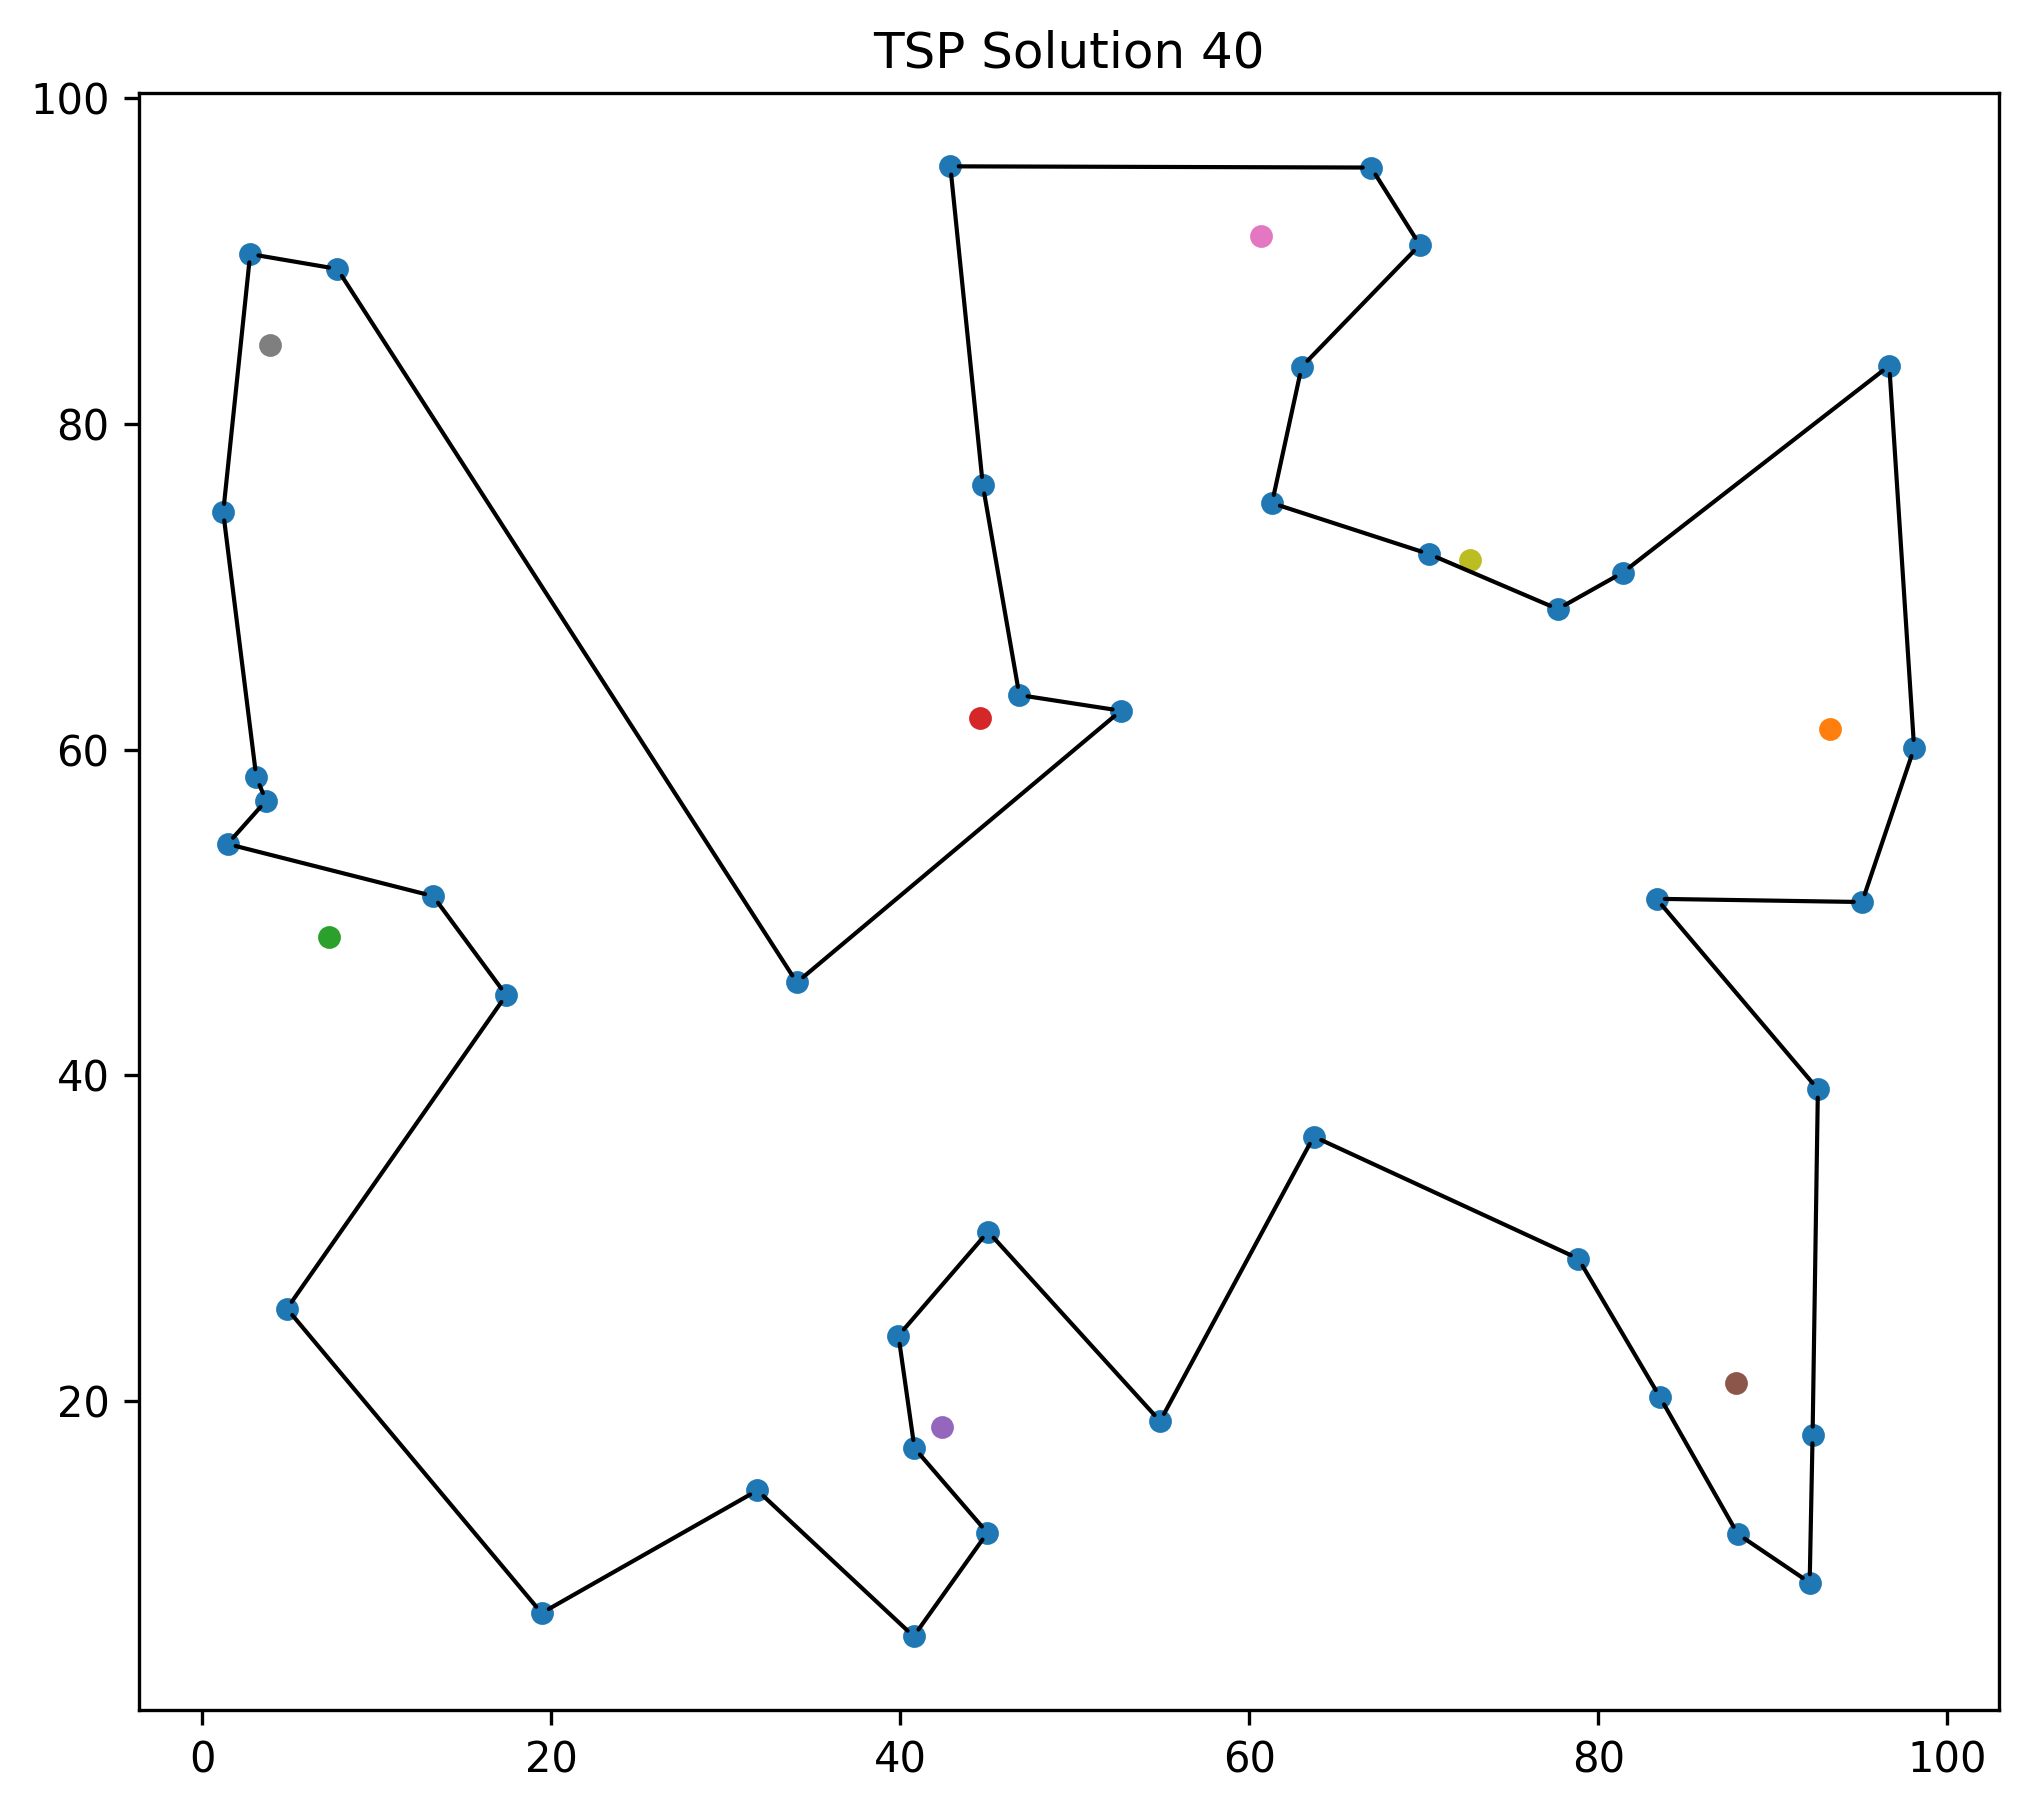

539


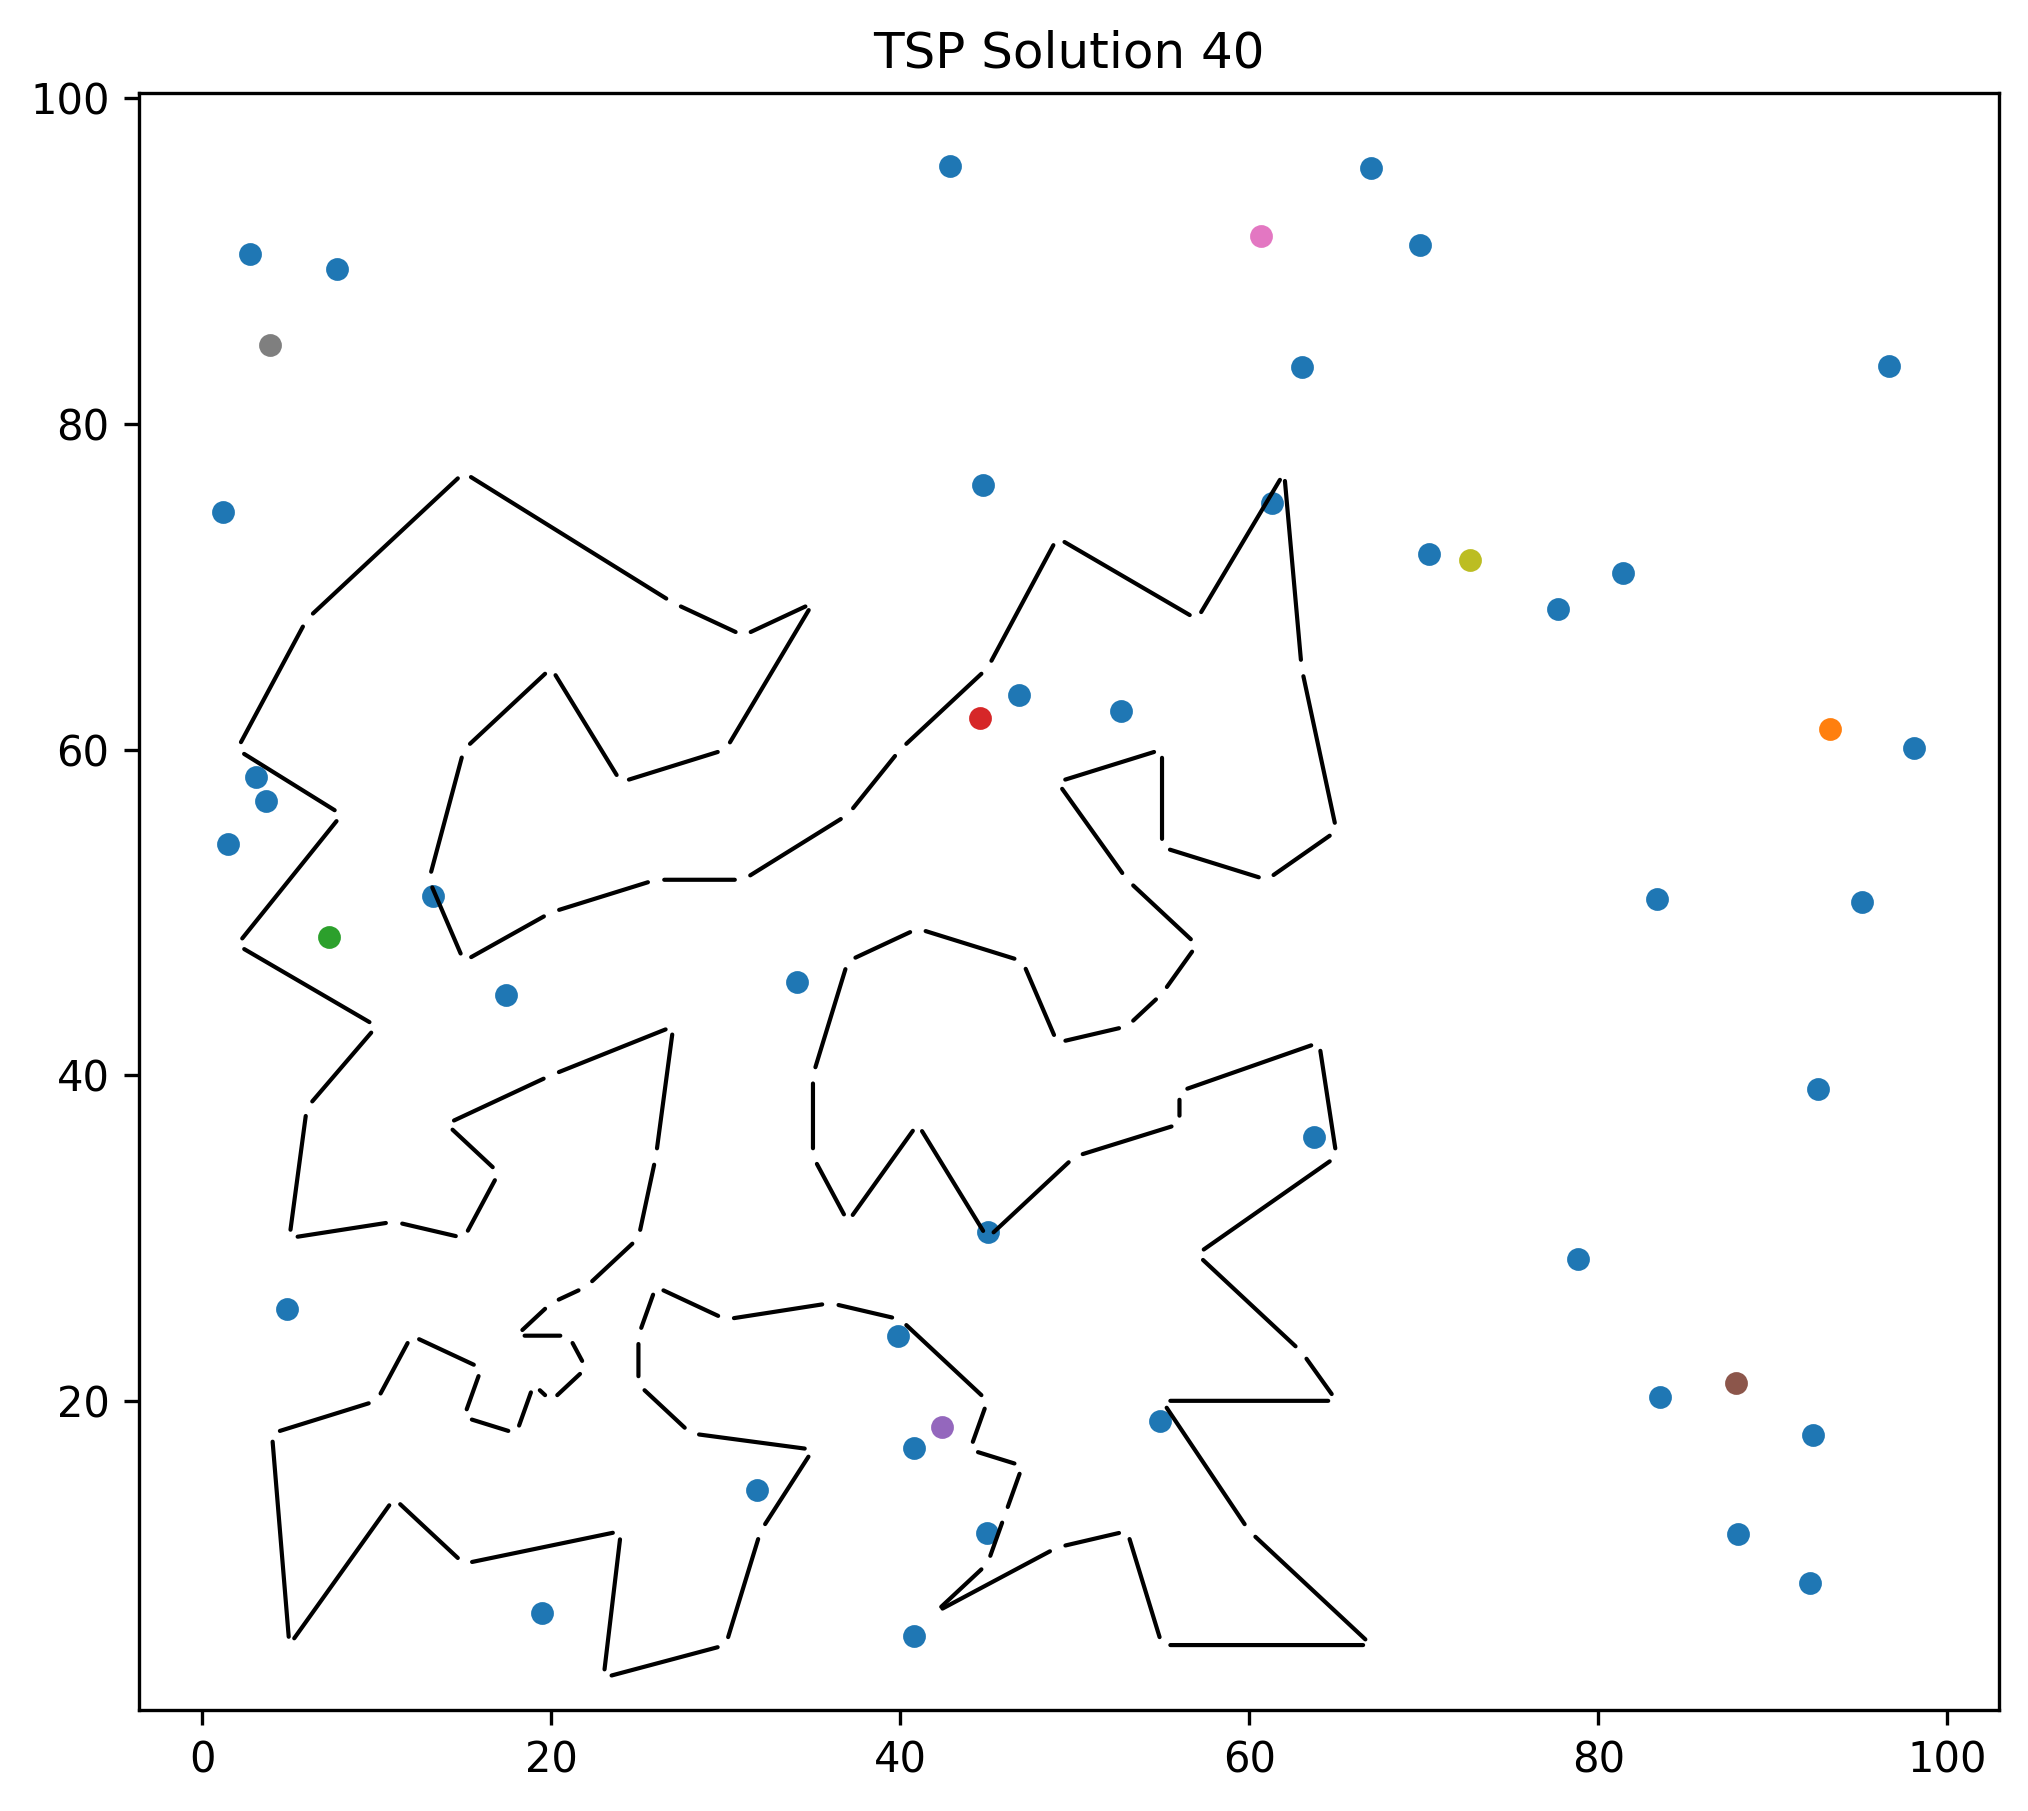

629


In [19]:
# 50 points
render_tsp(solution, save=True, figsize=(8,7), dpi=300)

arc_solution = tsp_distance(solution)
print(arc_solution)

render_tsp([tour_points[i] for i in opt_tour_solution], optimal=True, save=True, figsize= (8, 7), dpi=300)

optimum = tsp_distance([tour_points[i] for i in opt_tour_solution])
print(optimum)

# 2793 ej rounded 2784 rounded